In [1]:
import plumed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib

matplotlib.rcParams['svg.fonttype'] = 'none'

from SCRIPTS.func_block import reweight_3d, read_fes_3d, dG_calc
from SCRIPTS.func_plot import plot_prof

from SCRIPTS.func_block_prot_review import *

import warnings
warnings.filterwarnings("ignore")
import scipy.ndimage


# from scipy.ndimage import gaussian_filter

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
SF = [0.8, 0.85, 1]
IONS = ['MG', 'CA']

STRUCT = 'adapted'

FOLDERS = {
    'MG_0.8':f'S5-S6_{STRUCT}-MG/mw_0.8',
    'CA_0.8':f'S5-S6_{STRUCT}-CA/mw_0.8',
    'CA_0.85':f'S5-S6_{STRUCT}-CA/mw_0.85',

}

PROF_NAME = {
    'MG_0.8': {'pref': 'att6', 'npts': 200, 'stepmax': 200}, 
    'CA_0.8':  {'pref': 'att0', 'npts': 200, 'stepmax': 200}, 
    'CA_0.85': {'pref': 'att0', 'npts': 200, 'stepmax': 200}
}

colors = {
    'CA_0.8': 'green',
    'CA_0.85': 'blue',
    'CA_1':'grey',
    'MG_0.8':'magenta',
    'MG_1':'r',

}

# STRUCT = 'apo'

# FOLDERS = {
#     'MG_0.8':f'S5-S6_{STRUCT}-MG/mw_0.8',
#     'CA_0.85':f'S5-S6_{STRUCT}-CA/mw_0.85',

# }

# PROF_NAME = {
#     'MG_0.8': None,#{'pref': 'att6', 'npts': 200, 'stepmax': 200}, 
#     'CA_0.85': None #{'pref': 'att0', 'npts': 200, 'stepmax': 200}
# }

# colors = {
#     'CA_0.8': 'green',
#     'CA_0.85': 'blue',
#     'CA_1':'grey',
#     'MG_0.8':'magenta',
#     'MG_1':'r',

# }


Tmin=0 #0.5 #us
Tmax=2 #us


kBT=310*8.314462618*0.001 # kJ/mol
CV = ['dp1', 'dp2', 'cn']

In [3]:
COLVARS = {}
for (k, v) in FOLDERS.items():
    print(k,v)
    cvlr = plumed.read_as_pandas(f'{v}/COLVAR')
    COLVARS[k] = cvlr[(Tmin*1000**2 <= cvlr['time'])]# & (cvlr['time'] < Tmax*1000**2)]

MG_0.8 S5-S6_adapted-MG/mw_0.8


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++


CA_0.8 S5-S6_adapted-CA/mw_0.8


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++


CA_0.85 S5-S6_adapted-CA/mw_0.85


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++


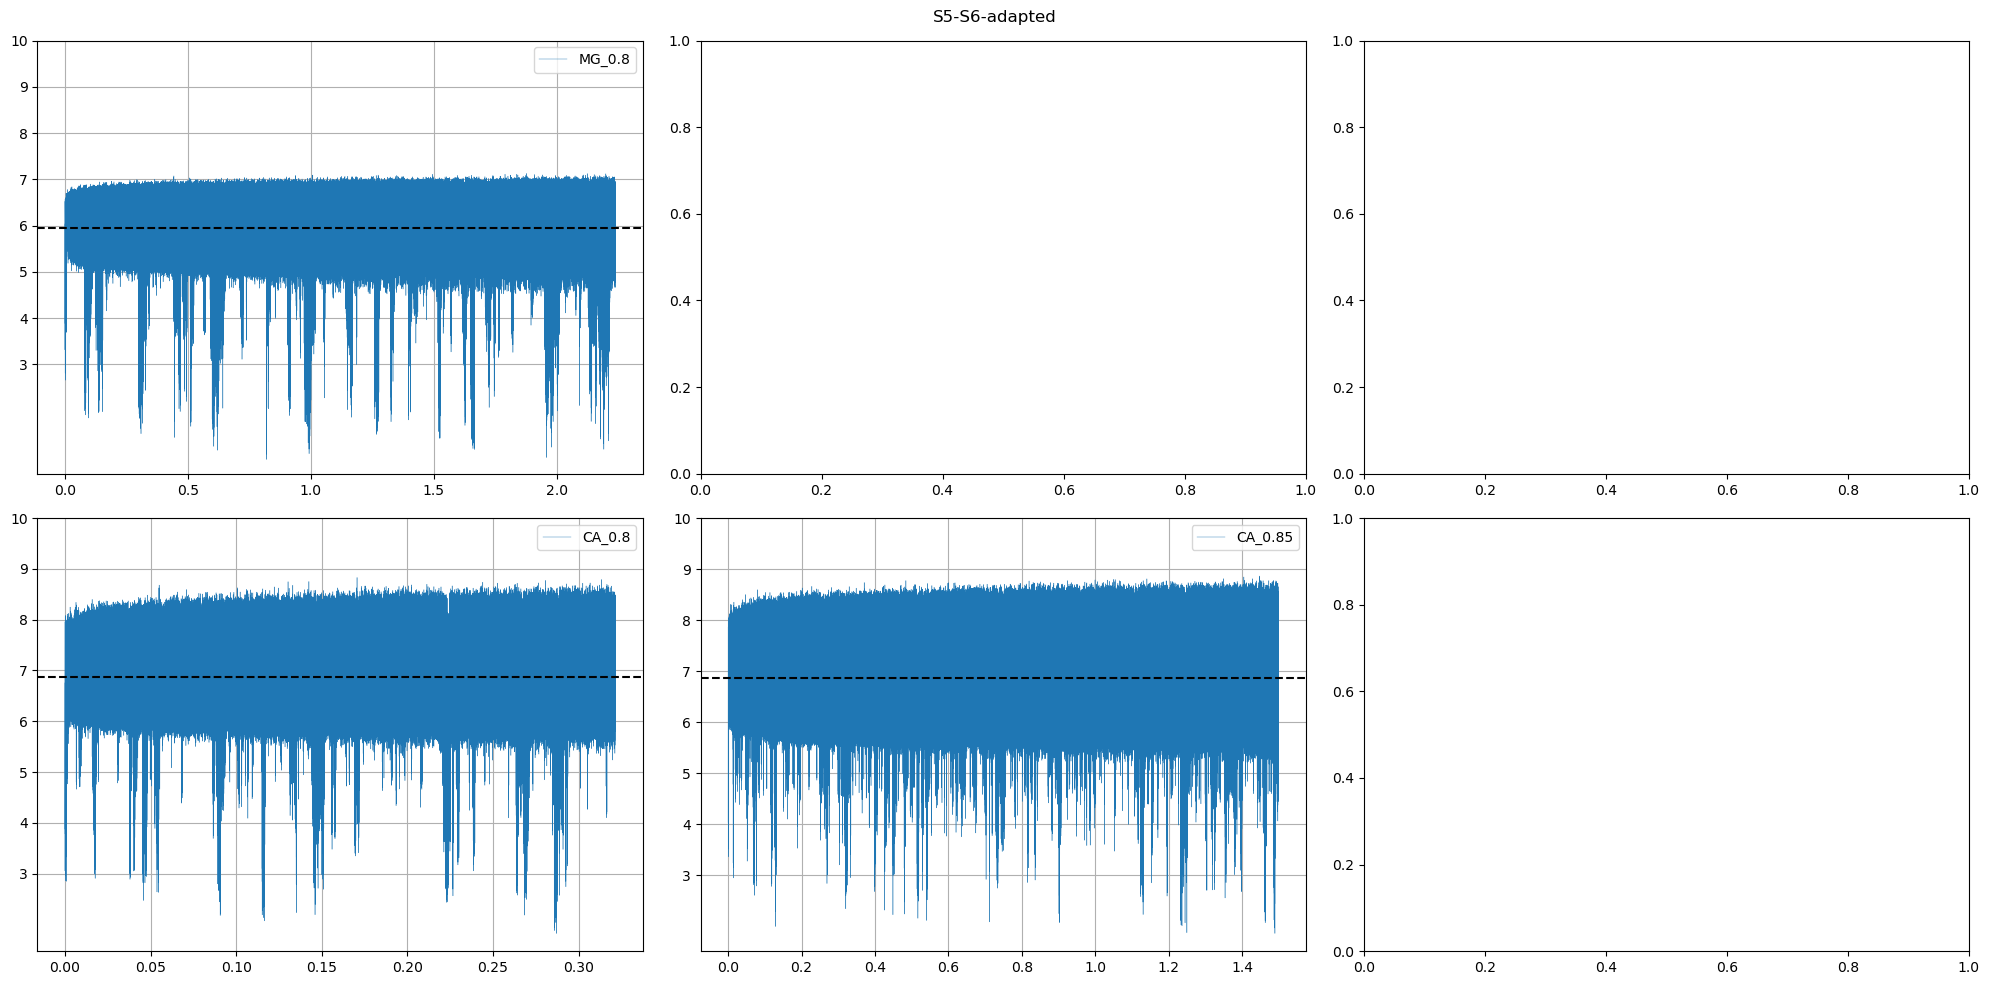

In [4]:
fig, ax = plt.subplots(len(IONS), len(SF), figsize = (20, 10))
for i in range(len(IONS)):
    for j in range(len(SF)):
        s = f'{IONS[i]}_{SF[j]}'
        if s in FOLDERS.keys():
            ax[i][j].plot(COLVARS[s]['time']/1000**2, COLVARS[s]['cn'], label = s, lw=0.3)
            ax[i][j].legend()
            ax[i][j].set_yticks([3, 4, 5, 6, 7, 8, 9, 10])
            ax[i][j].grid()
            ax[i][j].axhline(np.mean(COLVARS[s]['cn']), linestyle = '--', color = 'k')
            #ax[i][j].set_xlim(0, 3)
plt.suptitle(f'S5-S6-{STRUCT}')
plt.tight_layout()
# plt.savefig(f'IMAGES/S5-S6-{STRUCT}_COLVAR_CN.svg', dpi=300, bbox_inches = 'tight')

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++


243 243 196 [0.0342376, 4.30931] [0.0285847, 4.29799] [0.594477, 7.48164]


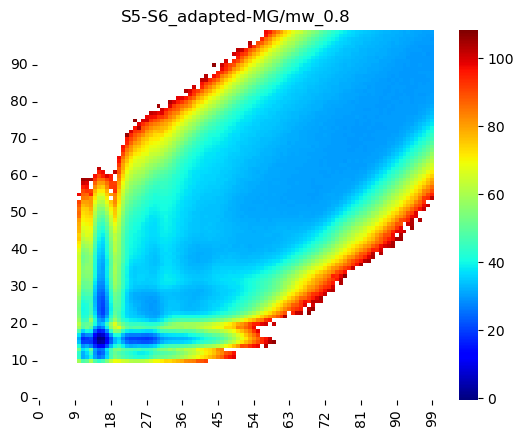

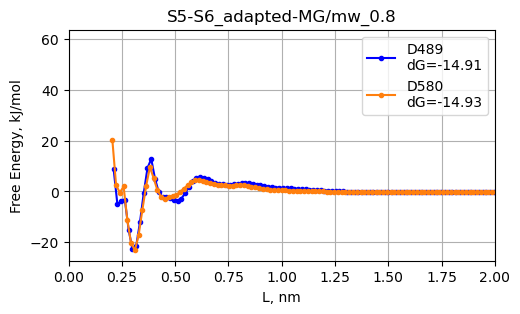

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++


232 235 210 [0.0758954, 4.15059] [0.0758448, 4.2035] [1.71578, 9.10359]


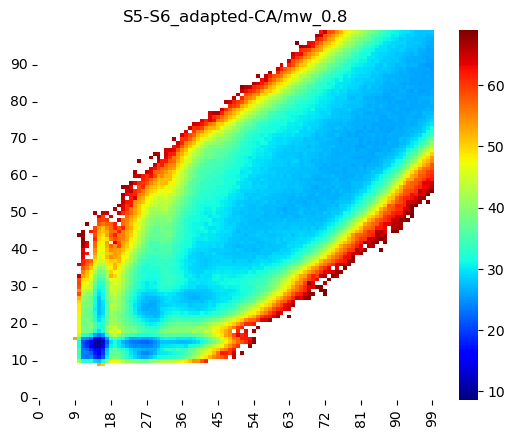

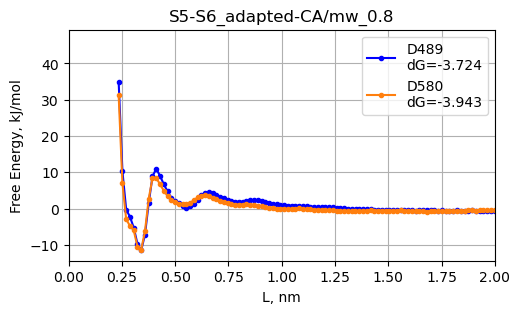

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++


240 241 219 [0.0698814, 4.28878] [0.0639515, 4.29056] [1.518, 9.21719]


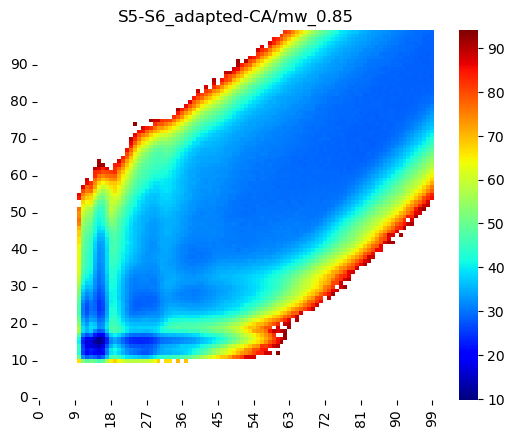

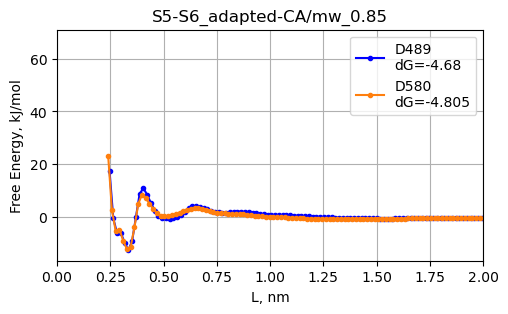

In [5]:
dist1, dist2, cn, fes, Nbins_D1, Nbins_D2, Nbins_CN, Bonds_D1, Bonds_D2, Bonds_CN = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}
for (k, v) in FOLDERS.items():    
    dist1[k], dist2[k], cn[k], fes[k], Nbins_D1[k], Nbins_D2[k], Nbins_CN[k], Bonds_D1[k], Bonds_D2[k], Bonds_CN[k] = read_fes_3d(v)
    # print(Nbins_D1, Nbins_D2, Nbins_CN, Bonds_D1, Bonds_D2, Bonds_CN)
    reweight_3d(COLVARS[k], 
                dist1[k], dist2[k], cn[k], fes[k], 
                Nbins_D1[k], Nbins_D2[k], Nbins_CN[k], Bonds_D1[k], Bonds_D2[k], Bonds_CN[k],
                v, plot=True, FIG_FOLDER=f'{v}/reweight'
                )

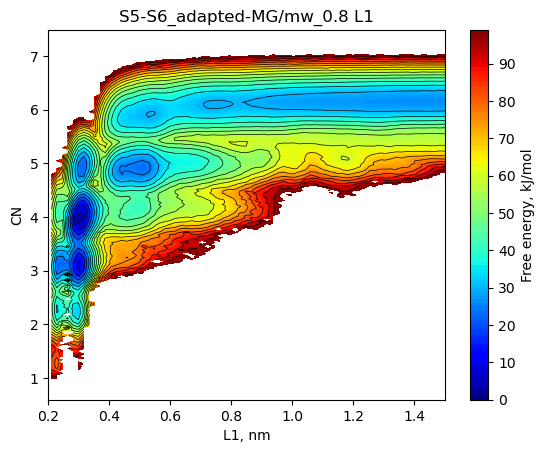

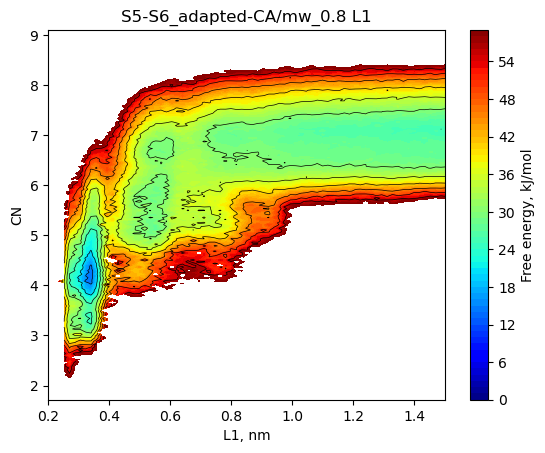

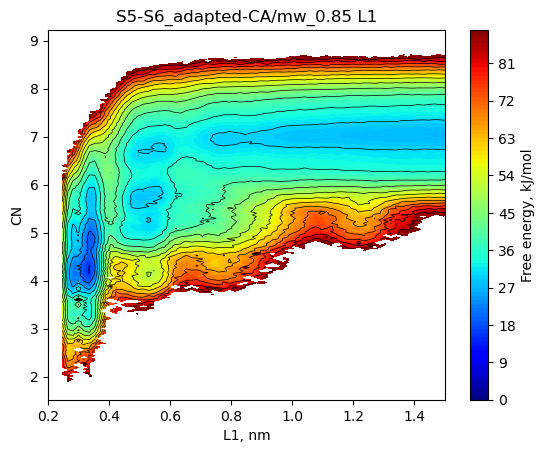

In [6]:
for (k, v) in FOLDERS.items():
    plot_2d_d_cn(1, k, COLVARS[k], 
                dist1[k], dist2[k], cn[k], fes[k], 
                Nbins_D1[k], Nbins_D2[k], Nbins_CN[k], Bonds_D1[k], Bonds_D2[k], Bonds_CN[k],
                FOLDERS
                )


In [7]:
k = 'MG_0.8'
COLVARS[k][(abs(COLVARS[k]['d_489']-1.2) <= 0.1) & (abs(COLVARS[k]['d_580']-0.8) <= 0.1)]

,time,d_489,d_580,cn,d_484,d_576
73,18.0,1.109046,0.834781,6.337202,1.095268,1.295003
77,19.0,1.138767,0.886134,6.085124,1.138186,1.285778
93,23.0,1.137998,0.889372,6.082762,1.139097,1.307210
109,27.0,1.207419,0.885324,6.216585,1.166019,1.308167
129,32.0,1.117618,0.892557,5.910786,1.127060,1.223530
...,...,...,...,...,...,...
8924426,2231106.0,1.139287,0.738224,6.422032,1.326865,1.042703
8924430,2231107.0,1.250886,0.849088,6.543302,1.462394,1.140625
8924434,2231108.0,1.284686,0.797558,6.460046,1.406965,1.158574
8924438,2231109.0,1.280255,0.799543,6.438110,1.374410,1.155506


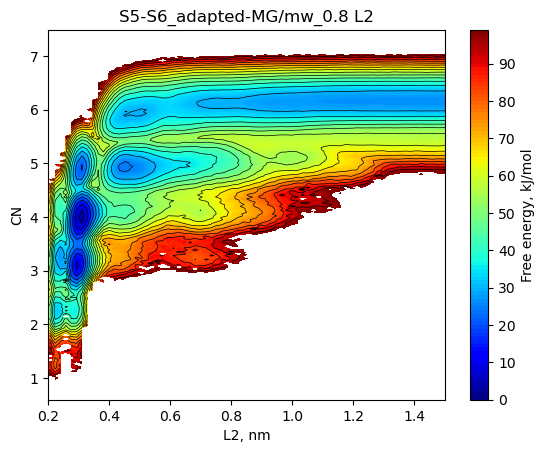

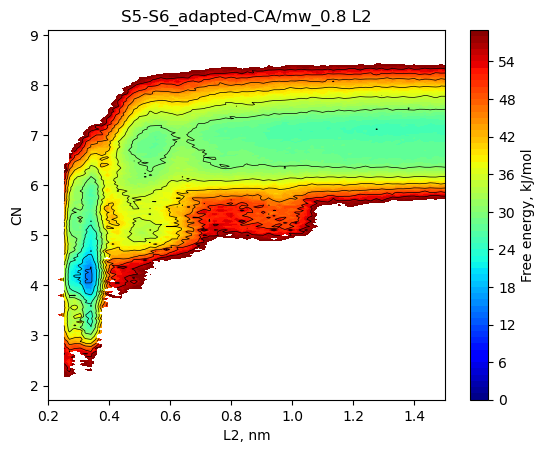

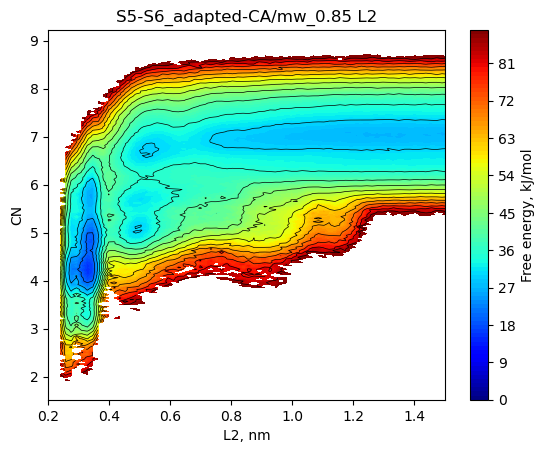

In [8]:
for (k, v) in FOLDERS.items():
    plot_2d_d_cn(2, k, COLVARS[k], 
                dist1[k], dist2[k], cn[k], fes[k], 
                Nbins_D1[k], Nbins_D2[k], Nbins_CN[k], Bonds_D1[k], Bonds_D2[k], Bonds_CN[k],
                FOLDERS
                )


In [9]:
D1, D2, FES_2D = {}, {}, {}
for (k, v) in FOLDERS.items():
    D1[k], D2[k], FES_2D[k] = read_fes(k, FOLDERS)

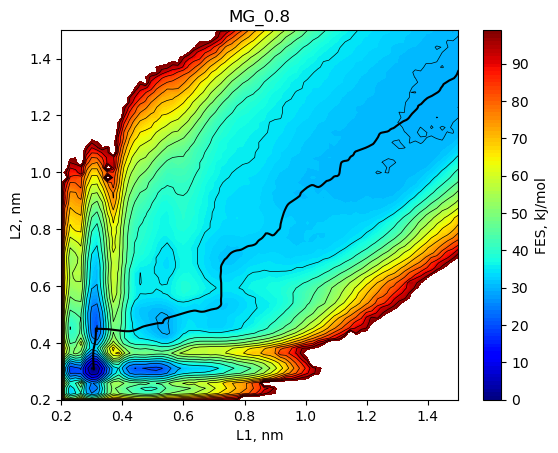

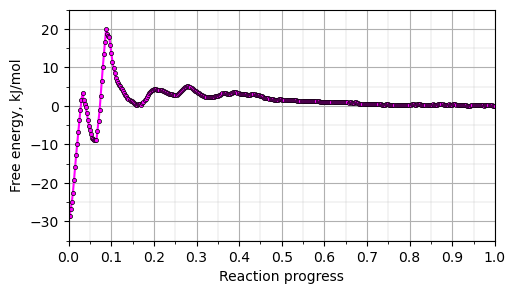

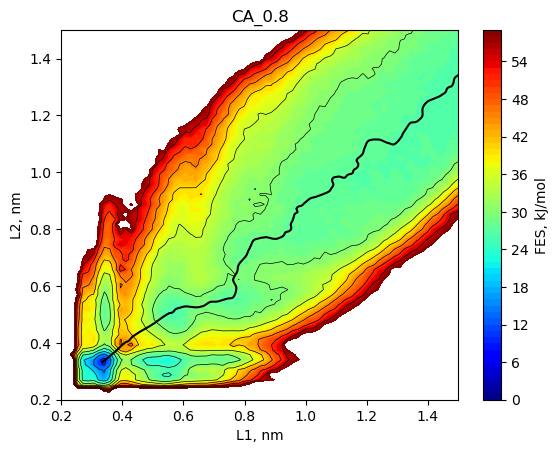

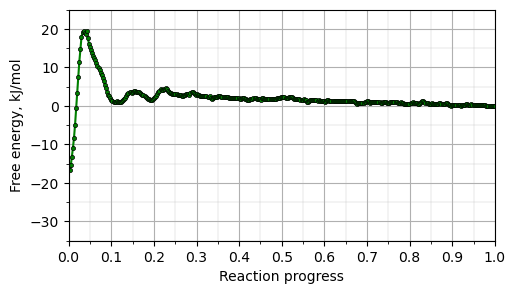

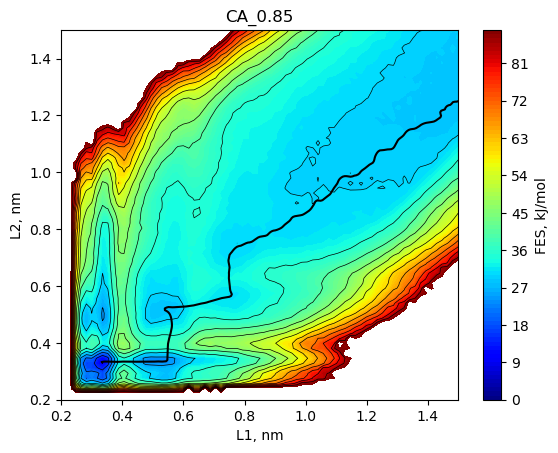

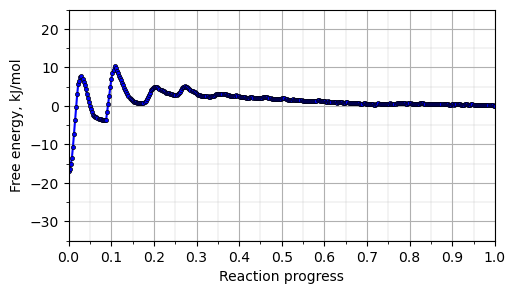

In [10]:
for (k, v) in FOLDERS.items():
    plot_2d(D1[k], D2[k], FES_2D[k], k, PROF_NAME[k], FOLDERS, colors)

-14.909962396639003 -14.930116908378887


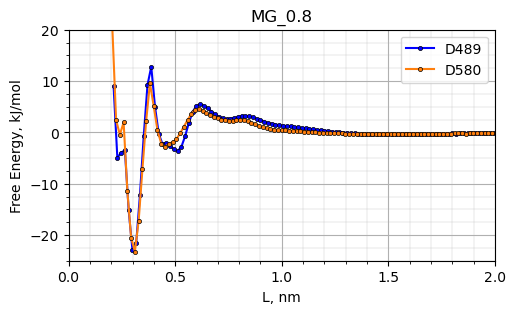

-3.7243817772310837 -3.9428531550535197


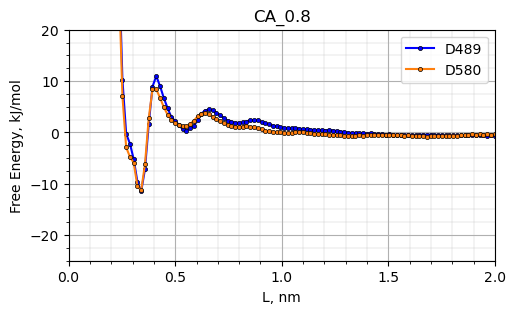

-4.68003693780786 -4.8051662674867845


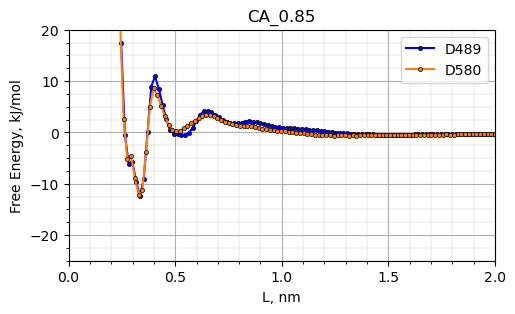

In [11]:
for (k, v) in FOLDERS.items():
    plot_1d(D1[k], D2[k], k)


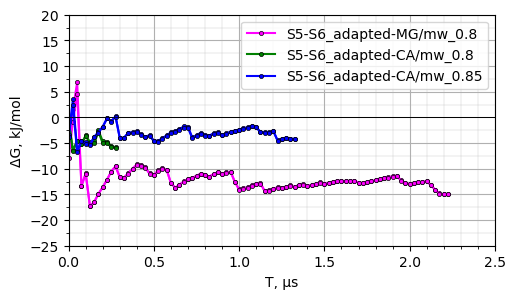

In [12]:
fig, ax = plt.subplots(figsize = (5.5, 3))

for (k, v) in FOLDERS.items():
    plot_stride_dG(k, ax, FOLDERS, colors)

In [ ]:
# for (k, v) in FOLDERS.items():
#     calc_dGmeanstd(
#         COLVARS[k], 
#         dist1[k], dist2[k], cn[k], fes[k], 
#         Nbins_D1[k], Nbins_D2[k], Nbins_CN[k], Bonds_D1[k], Bonds_D2[k], Bonds_CN[k],
#         FOLDERS[k]
#     )

100%|██████████| 22/22 [08:12<00:00, 22.40s/it]


In [75]:
def darken_color(color, factor=0.5):
    rgb = matplotlib.colors.to_rgb(color)
    return tuple(max(0, x * factor) for x in rgb)

def format_labels(x, pos):
    if x < 1:
        return f'{x:.1f}'
    else: 
        return x



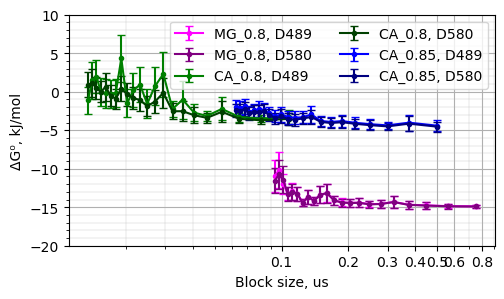

In [76]:
fig, ax = plt.subplots(figsize = (5.5, 3))

for (k, v) in FOLDERS.items():
    df = pd.read_csv(f'{FOLDERS[k]}/block_analysis.csv', sep=' ')
    df = df.rename(columns={df.columns[i]:df.columns[i+1] for i in range(len(df.columns)-1)}).dropna(axis=1, how='all')
    plt.errorbar(len(COLVARS[k])/df['N_blocks']/(4*1000**2), df['dG1_mean'], df['dG1_std'], fmt='.-', color = colors[k],
                capsize=3, 
                #markeredgecolor = 'k',
                label = f'{k}, D489'
                )
    plt.errorbar(len(COLVARS[k])/df['N_blocks']/(4*1000**2), df['dG2_mean'], df['dG2_std'], fmt='.-', 
                 color = darken_color(colors[k]),
                capsize=3, 
                #markeredgecolor = 'k',

                label = f'{k}, D580'
                )



plt.xlabel('Block size, us')
plt.ylabel('ΔG⁰, kJ/mol')

ax.grid(True, which='major', linestyle='-')
ax.grid(True, which='minor', linestyle='-', lw=0.2)
ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(-30, 30, 5)))
ax.yaxis.set_minor_locator(matplotlib.ticker.FixedLocator(np.arange(-30, 30, 1)))

# ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
plt.ylim(-20, 10)
plt.legend(ncols=2)

ax.set_xscale('log')
ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.array([0.1, 1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20])*10**2/1000))
ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(format_labels))

# plt.xlim(0.2, 2)
plt.savefig(f'IMAGES/prot_block_dG_mean.svg', bbox_inches = 'tight', dpi=300)

plt.show()

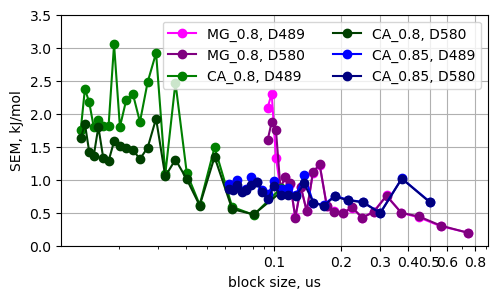

In [77]:
fig, ax = plt.subplots(figsize = (5.5, 3))

for (k, v) in FOLDERS.items():
    df = pd.read_csv(f'{FOLDERS[k]}/block_analysis.csv', sep=' ')
    df = df.rename(columns={df.columns[i]:df.columns[i+1] for i in range(len(df.columns)-1)}).dropna(axis=1, how='all')

    plt.plot(len(COLVARS[k])/df['N_blocks']/(4*1000**2), df['dG1_std'], 'o-', 
            color = colors[k],
            label = f'{k}, D489'
        )
    plt.plot(len(COLVARS[k])/df['N_blocks']/(4*1000**2), df['dG2_std'], 'o-',
                color = darken_color(colors[k]),
                label = f'{k}, D580'
                )


plt.ylabel('SEM, kJ/mol')
plt.grid()
plt.xlabel('block size, us')
plt.xscale('log')

# ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(-30, 30, 5)))
# ax.yaxis.set_minor_locator(matplotlib.ticker.FixedLocator(np.arange(-30, 30, 1)))

# # ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
plt.ylim(0, 3.5)
plt.legend(ncols=2)

# Указываем конкретные значения для подписей оси X
ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.array([0.1, 1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20])*10**2/1000))


ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(format_labels))
plt.savefig(f'IMAGES/prot_block_dG_std.svg', bbox_inches = 'tight', dpi=300)

plt.show()